In [2]:
import os
import datetime
import pandas as pd
import glob



## Load the Data

In [4]:
data_input_dir = "../data/processed"
rides_dir = os.path.join(data_input_dir, "ep", "rides_nonoperating_bucket")
splits_output_dir = "../data/processed/bucket_splits"
os.makedirs(splits_output_dir, exist_ok=True)

## Get all ride parquet files
ride_files = glob.glob(os.path.join(rides_dir, "*.parquet"))
print(f"Found {len(ride_files)} ride files")


Found 31 ride files


## Create the Splits

We will split the data into a training, validation and test set using the following methology:
- 2017 - 2022: Training
- 2023: Validation
- 2024: Test

This approximates a commonly used 80/10/10 split.

In [5]:
all_train_indices = []
all_validation_indices = []
all_test_indices = []

for ride_file in ride_files:
    ride_name = os.path.basename(ride_file).replace(".parquet", "")
    print(f"Processing ride: {ride_name}")
    
    ride_df = pd.read_parquet(ride_file)
    print(f"  Shape: {ride_df.shape}")
    print(ride_df.columns)

    train_indices = ride_df[ride_df["time_bucket"] < datetime.datetime(2023, 1, 1)].index
    validation_indices = ride_df[(ride_df["time_bucket"] >= datetime.datetime(2023, 1, 1)) & 
                                (ride_df["time_bucket"] < datetime.datetime(2024, 1, 1))].index
    test_indices = ride_df[ride_df["time_bucket"] >= datetime.datetime(2024, 1, 1)].index
    
    if len(train_indices) > 0:
        train_data = pd.DataFrame({
            'ride_name': ride_name,
            'original_index': train_indices
        })
        all_train_indices.append(train_data)
    
    if len(validation_indices) > 0:
        validation_data = pd.DataFrame({
            'ride_name': ride_name,
            'original_index': validation_indices
        })
        all_validation_indices.append(validation_data)
    
    if len(test_indices) > 0:
        test_data = pd.DataFrame({
            'ride_name': ride_name,
            'original_index': test_indices
        })
        all_test_indices.append(test_data)
    
    print(f"  Train: {len(train_indices)}, Validation: {len(validation_indices)}, Test: {len(test_indices)}")
    

    if len(train_indices) > 0:
        print("  Train timestamps sample:")
        print(f"    First: {ride_df.loc[train_indices[0:min(5, len(train_indices))], 'time_bucket'].tolist()}")
        print(f"    Last: {ride_df.loc[train_indices[-min(5, len(train_indices)):], 'time_bucket'].tolist()}")
    
    if len(validation_indices) > 0:
        print("  Validation timestamps sample:")
        print(f"    First: {ride_df.loc[validation_indices[0:min(5, len(validation_indices))], 'time_bucket'].tolist()}")
        print(f"    Last: {ride_df.loc[validation_indices[-min(5, len(validation_indices)):], 'time_bucket'].tolist()}")
    
    if len(test_indices) > 0:
        print("  Test timestamps sample:")
        print(f"    First: {ride_df.loc[test_indices[0:min(5, len(test_indices))], 'time_bucket'].tolist()}")
        print(f"    Last: {ride_df.loc[test_indices[-min(5, len(test_indices)):], 'time_bucket'].tolist()}")
    
    print()
    
    



combined_train_indices = pd.concat(all_train_indices) if all_train_indices else pd.DataFrame(columns=['ride_name', 'original_index'])
combined_validation_indices = pd.concat(all_validation_indices) if all_validation_indices else pd.DataFrame(columns=['ride_name', 'original_index'])
combined_test_indices = pd.concat(all_test_indices) if all_test_indices else pd.DataFrame(columns=['ride_name', 'original_index'])


print("Final split sizes:")
print(f"Training: {len(combined_train_indices)}")
print(f"Validation: {len(combined_validation_indices)}")
print(f"Test: {len(combined_test_indices)}")


Processing ride: volo_da_vinci
  Shape: (30106, 69)
Index(['timestamp', 'wait_time', 'closed', 'is_german_holiday',
       'is_swiss_holiday', 'is_french_holiday', 'time_bucket', 'day_of_week',
       'temperature', 'rain', 'weekday', 'is_weekend', 'month_sin',
       'month_cos', 'hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos',
       'minute_sin', 'minute_cos', 'temperature_unscaled', 'rain_unscaled',
       'ride_name_alpine express enzian',
       'ride_name_arena of football  be part of it', 'ride_name_arthur',
       'ride_name_atlantica supersplash', 'ride_name_atlantis adventure',
       'ride_name_baaa express', 'ride_name_blue fire megacoaster',
       'ride_name_castello dei medici', 'ride_name_dancing dingie',
       'ride_name_euromir', 'ride_name_eurosat  cancan coaster',
       'ride_name_eurotower', 'ride_name_fjordrafting',
       'ride_name_jim button  journey through morrowland',
       'ride_name_josefinas magical imperial journey',
       'ride_name_kolumbusjo

Check the shapes of the splits to ensure they contain the correct number of rows.

In [6]:
combined_train_indices.shape, combined_validation_indices.shape, combined_test_indices.shape

((663140, 2), (126983, 2), (114173, 2))

Finally, we save the splits to parquet files for further use.

In [7]:
combined_train_indices

,ride_name,original_index
0,volo_da_vinci,0
1,volo_da_vinci,1
2,volo_da_vinci,2
3,volo_da_vinci,3
4,volo_da_vinci,4
...,...,...
21973,silver_star,21973
21974,silver_star,21974
21975,silver_star,21975
21976,silver_star,21976


In [8]:
train_output_file = os.path.join(splits_output_dir, "train_indices.parquet")
validation_output_file = os.path.join(splits_output_dir, "validation_indices.parquet")
test_output_file = os.path.join(splits_output_dir, "test_indices.parquet")

combined_train_indices.to_parquet(train_output_file, index=False)
combined_validation_indices.to_parquet(validation_output_file, index=False)
combined_test_indices.to_parquet(test_output_file, index=False)

print(f"Saved splits to {splits_output_dir}")

Saved splits to ../data/processed/bucket_splits


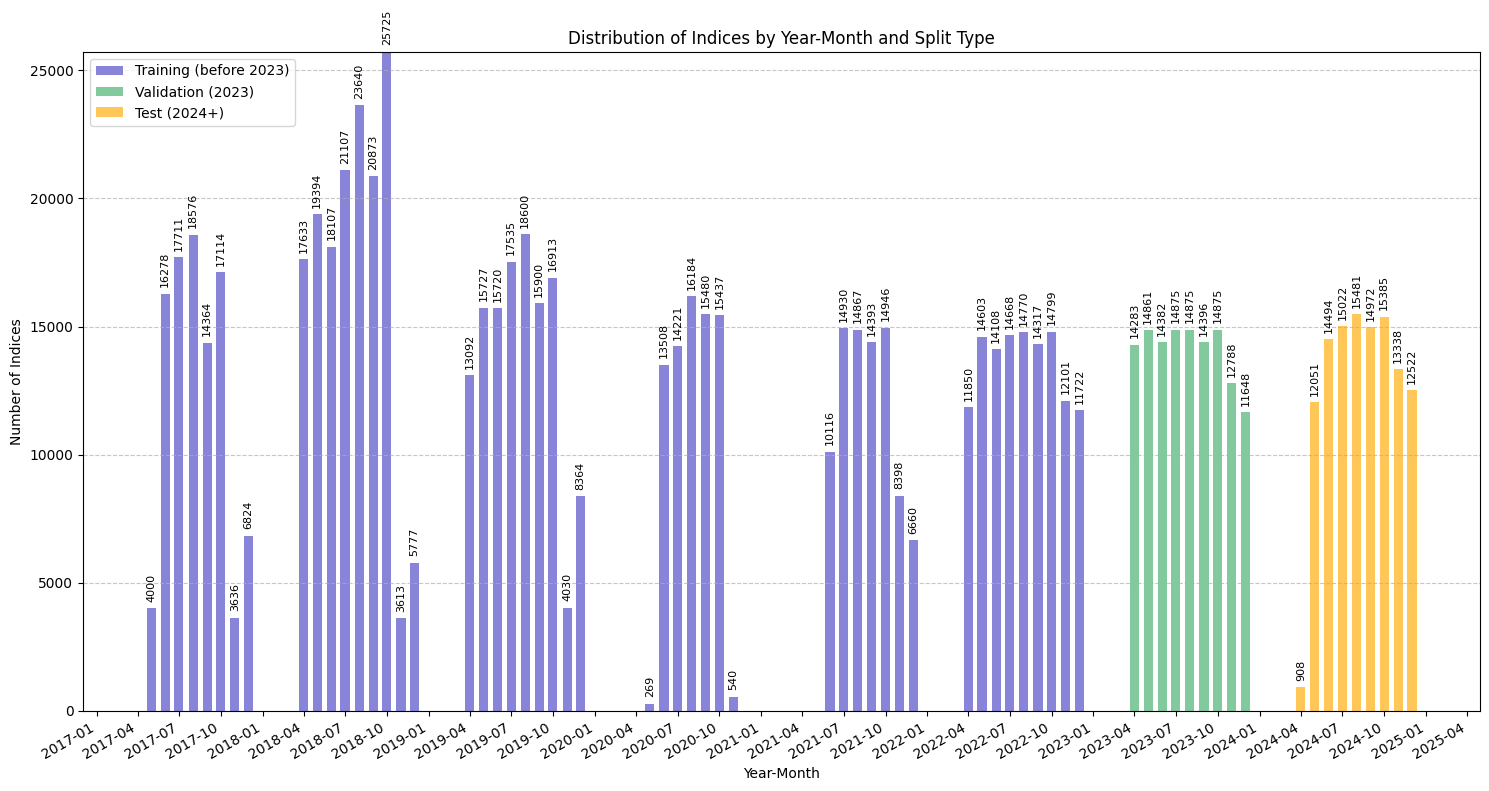

Summary of index distribution:
Total Training indices: 663,140
Total Validation indices: 126,983
Total Test indices: 114,173
Grand Total: 904,296

Top 5 months by total count:
   year_month  train  validation  test  total
14    2018-10  25725           0     0  25725
12    2018-08  23640           0     0  23640
11    2018-07  21107           0     0  21107
13    2018-09  20873           0     0  20873
9     2018-05  19394           0     0  19394


In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
import datetime  # Correct import

# Create a dataframe to store the year-month counts
year_month_counts = {}

# Process each ride file to collect year-month distribution data
for ride_file in ride_files:
    ride_name = os.path.basename(ride_file).replace(".parquet", "")
    ride_df = pd.read_parquet(ride_file)
    
    # Add year-month column
    ride_df['year_month'] = ride_df['time_bucket'].dt.strftime('%Y-%m')
    
    # Count by year-month for each split
    # Fix the datetime reference
    train_counts = ride_df[ride_df["time_bucket"] < datetime.datetime(2023, 1, 1)].groupby('year_month').size()
    val_counts = ride_df[(ride_df["time_bucket"] >= datetime.datetime(2023, 1, 1)) & 
                        (ride_df["time_bucket"] < datetime.datetime(2024, 1, 1))].groupby('year_month').size()
    test_counts = ride_df[ride_df["time_bucket"] >= datetime.datetime(2024, 1, 1)].groupby('year_month').size()
    
    # Update the dictionary
    for year_month, count in train_counts.items():
        if year_month not in year_month_counts:
            year_month_counts[year_month] = {'train': 0, 'validation': 0, 'test': 0}
        year_month_counts[year_month]['train'] += count
    
    for year_month, count in val_counts.items():
        if year_month not in year_month_counts:
            year_month_counts[year_month] = {'train': 0, 'validation': 0, 'test': 0}
        year_month_counts[year_month]['validation'] += count
    
    for year_month, count in test_counts.items():
        if year_month not in year_month_counts:
            year_month_counts[year_month] = {'train': 0, 'validation': 0, 'test': 0}
        year_month_counts[year_month]['test'] += count

# Convert to DataFrame
distribution_df = pd.DataFrame.from_dict(year_month_counts, orient='index')
distribution_df.index.name = 'year_month'
distribution_df.reset_index(inplace=True)

# Convert year_month to datetime for better plotting
distribution_df['datetime'] = pd.to_datetime(distribution_df['year_month'] + '-01')
distribution_df = distribution_df.sort_values('datetime')

# Plot the distribution
plt.figure(figsize=(15, 8))

# Create stacked bar chart
bottom_data = np.zeros(len(distribution_df))

# Training data
train_bars = plt.bar(distribution_df['datetime'], distribution_df['train'], 
                     label='Training (before 2023)', width=20, align='center',
                     color='#8884d8')

# Validation data
val_bars = plt.bar(distribution_df['datetime'], distribution_df['validation'], 
                   bottom=distribution_df['train'], label='Validation (2023)',
                   width=20, align='center', color='#82ca9d')

# Test data
test_bars = plt.bar(distribution_df['datetime'], distribution_df['test'],
                   bottom=distribution_df['train'] + distribution_df['validation'], 
                   label='Test (2024+)', width=20, align='center', color='#ffc658')

# Format the x-axis to show years and months
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Show every 3 months
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format as YYYY-MM
plt.gcf().autofmt_xdate()  # Rotate date labels

# Add labels and title
plt.xlabel('Year-Month')
plt.ylabel('Number of Indices')
plt.title('Distribution of Indices by Year-Month and Split Type')
plt.legend(loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add totals on top of the chart
for i in range(len(distribution_df)):
    total = distribution_df.iloc[i]['train'] + distribution_df.iloc[i]['validation'] + distribution_df.iloc[i]['test']
    if total > 0:  # Only add text for bars with data
        plt.text(distribution_df.iloc[i]['datetime'], total + max(distribution_df['train'] + distribution_df['validation'] + distribution_df['test']) * 0.01,
                f'{int(total)}', ha='center', va='bottom', rotation=90, fontsize=8)

# Tight layout
plt.tight_layout()

# Show the plot
plt.show()

# Print summary statistics
print("Summary of index distribution:")
print(f"Total Training indices: {distribution_df['train'].sum():,}")
print(f"Total Validation indices: {distribution_df['validation'].sum():,}")
print(f"Total Test indices: {distribution_df['test'].sum():,}")
print(f"Grand Total: {(distribution_df['train'] + distribution_df['validation'] + distribution_df['test']).sum():,}")

# Show the months with highest counts
print("\nTop 5 months by total count:")
distribution_df['total'] = distribution_df['train'] + distribution_df['validation'] + distribution_df['test']
print(distribution_df.sort_values('total', ascending=False)[['year_month', 'train', 'validation', 'test', 'total']].head(5))